In [1]:
import deepSI
from NonlinearController.systems import SinCosUnbalancedDisc
import numpy as np
import matplotlib.pyplot as plt

In [67]:
# Nu = 50
# a = 3.6; flips = 500
# u = np.random.normal(0,1.0,Nu)
# for i in range(flips-1):
#     u = np.hstack((u, np.random.normal(a,.4,Nu)))
#     a = -1*a
#     u = np.hstack((u, np.random.normal(0,.3,Nu)))

Nu = 100000
a = 3.1
u = deepSI.deepSI.exp_design.multisine(Nu, pmax=Nu//4-1, n_crest_factor_optim=20)*a/2
u = np.clip(u, -a, a)

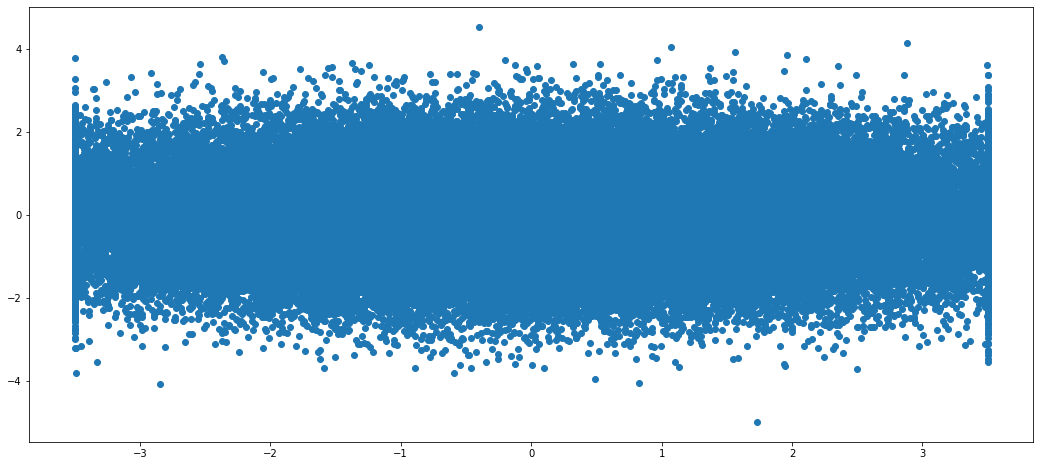

In [68]:
fig = plt.figure(figsize=(18,8))
plt.scatter(u, np.random.normal(0,1,u.size))
plt.show()

In [69]:
setup = SinCosUnbalancedDisc(dt=0.1, sigma_n=[0.014])
data = setup.apply_experiment(deepSI.System_data(u=u))

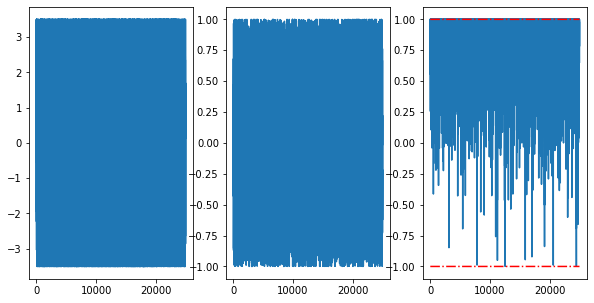

In [70]:
fig1 = plt.figure(figsize=(10,5))
plt_len = u.size//4
plt.subplot(1,3,1)
plt.plot(data.u[:plt_len])
plt.subplot(1,3,2)
plt.plot(data.y[:plt_len,0])
plt.subplot(1,3,3)
plt.plot(data.y[:plt_len,1])
plt.plot(np.ones(plt_len), 'r-.')
plt.plot(-1*np.ones(plt_len), 'r-.')
plt.show()

In [50]:
sys = deepSI.load_system('NonlinearController/trained_models/sincos/sincos_e40_b128_nf15_amp3_2_sn0_014')

In [51]:
train, test = data.train_test_split(split_fraction=0.2)
train, val  = train.train_test_split(split_fraction=0.25)

In [52]:
test_ss_enc = sys.apply_experiment(test)

NRMS simulation SS linear  11.28%


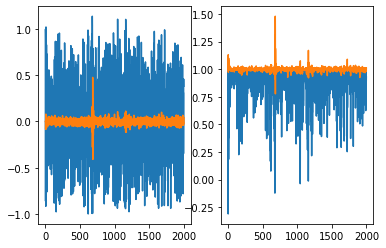

In [53]:
print(f'NRMS simulation SS linear  {test_ss_enc.NRMS(test):.2%}')

plt.subplot(1,2,1)
plt.plot(test_ss_enc.y[:,0], label="System")
plt.plot(test_ss_enc.y[:,0] - test.y[:,0], label='Error')

plt.subplot(1,2,2)
plt.plot(test_ss_enc.y[:,1], label="System")
plt.plot(test_ss_enc.y[:,1] - test.y[:,1] + 1, label='Error')

plt.show()

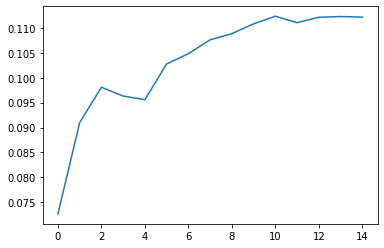

In [54]:
nsteperror = sys.n_step_error(test,nf=15)
plt.plot(nsteperror)